In [1]:
import time

import torch
import torch.nn as nn
from anyio import sleep
from numba.cuda.printimpl import print_item
from numpy import character
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
from solvers import riemann_solver_newton

import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
from generate import generate_balanced_training_data, generate_training_data

# Generate training data
num_samples = 4000
data = generate_balanced_training_data(riemann_solver_newton, num_samples_per_category=num_samples)
# data = generate_balanced_training_data(riemann_solver_newton, num_samples_per_category=num_samples)

# Save to CSV file
path = 'datasets/riemann_training_data_balanced2.csv'
data.to_csv(path, index=False)
print(f"Generated {num_samples} training samples and saved to '{path}'")


Generated 4000 training samples and saved to 'datasets/riemann_training_data_balanced2.csv'


In [12]:
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('datasets/riemann_training_data_balanced2.csv')  # Replace with your actual file path

# Select category
df = df[df['category'] != 8]

# Define input features and output features
X = df[['hL', 'huL', 'hR', 'huR']]
# X['ghL'] = np.sqrt(9.8066 * df['hL'])
# X['ghR'] = np.sqrt(9.8066 * df['hR'])
y = df[['h_star', 'u_star']]

# Split the data into training and validation sets
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['category'])

print(f"Training input shape: {train_X.shape}")
print(f"Validation input shape: {val_X.shape}")
print(f"Training output shape: {train_y.shape}")
print(f"Validation output shape: {val_y.shape}")


Training input shape: (25600, 4)
Validation input shape: (6400, 4)
Training output shape: (25600, 2)
Validation output shape: (6400, 2)


In [8]:
df['category'].value_counts()

category
0    4000
1    4000
2    4000
3    4000
4    4000
5    4000
6    4000
7    4000
Name: count, dtype: int64

In [13]:
# df = pd.read_csv('datasets/riemann_training_data3.csv')
g = 9.806
df['uL'] = df['huL'] / df['hL']
df['uR'] = df['huR'] / df['hR']
df['cL'] = (df['hL'] * g) ** 0.5
df['cR'] = (df['hR'] * g) ** 0.5
df.head()

,hL,huL,hR,huR,h_star,u_star,iter,category,uL,uR,cL,cR
0,0.500077,-8.133558,0.475049,-4.151462,0.009489,-12.445685,1,0,-16.264610,-8.739016,2.214443,2.158317
1,0.586884,-8.598580,1.737754,-8.504657,0.069284,-11.501745,1,0,-14.651237,-4.894052,2.398955,4.128003
2,1.522519,-9.177891,0.990116,-5.574348,1.171972,-5.080319,3,0,-6.028096,-5.629997,3.863913,3.115939
3,0.150738,-2.477218,0.410214,-1.505786,0.254574,-10.842184,1,0,-16.433899,-3.670730,1.215788,2.005633
4,1.560180,-8.439641,1.263517,-9.649840,1.856689,-6.122482,3,0,-5.409401,-7.637285,3.911410,3.519950


In [10]:
len(df)

8000

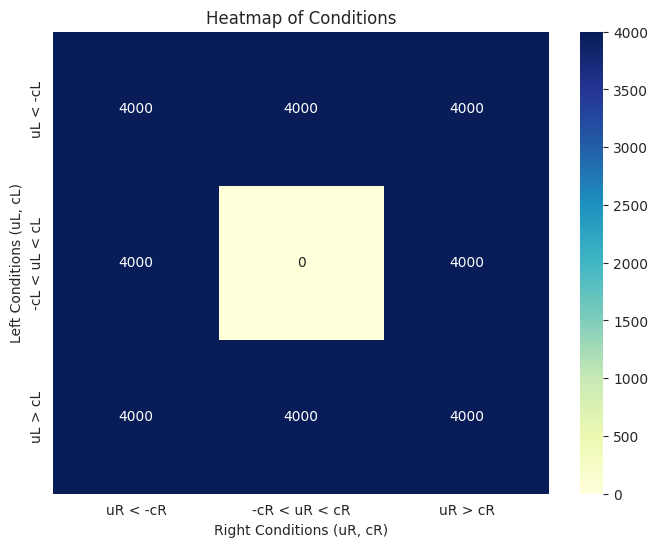

In [14]:
# Assuming `df` is your DataFrame
# Define the conditions for rows (uL, cL) and columns (uR, cR)
row_conditions = [
    df['uL'] < -df['cL'],
    (df['uL'] >= -df['cL']) & (df['uL'] <= df['cL']),
    df['uL'] > df['cL']
]

col_conditions = [
    df['uR'] < -df['cR'],
    (df['uR'] >= -df['cR']) & (df['uR'] <= df['cR']),
    df['uR'] > df['cR']
]

# Create a 3x3 matrix to store counts
heatmap_data = np.zeros((3, 3))

# Calculate counts for each combination of conditions
for i, row_cond in enumerate(row_conditions):
    for j, col_cond in enumerate(col_conditions):
        heatmap_data[i, j] = df[row_cond & col_cond].shape[0]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", xticklabels=['uR < -cR', '-cR < uR < cR', 'uR > cR'], yticklabels=['uL < -cL', '-cL < uL < cL', 'uL > cL'])
plt.title("Heatmap of Conditions")
plt.xlabel("Right Conditions (uR, cR)")
plt.ylabel("Left Conditions (uL, cL)")
plt.show()

In [15]:
# Convert pandas DataFrames to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 25600
Validation dataset size: 6400


In [16]:
train_dataset[0]

(tensor([ 0.2490, -2.3495,  3.8115, -2.7505]), tensor([ 0.2807, -9.6309]))

In [17]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

Training DataLoader batches: 400
Validation DataLoader batches: 100


In [18]:
from torch.nn.functional import relu, elu, batch_norm

In [19]:
class MLP(nn.Module):
    def __init__(self, input_features):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_features, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.layer4 = nn.Linear(20, 20)
        self.layer5 = nn.Linear(20, 2)
        self.activation = elu
        # self.bn = nn.BatchNorm1d(4)

    def forward(self, x):
        # if x.dim() == 1:
        #     x = x.unsqueeze(1)
        # x = self.bn(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.layer5(x)
        return x

# Example usage
input_features = 4  # Specify the number of input features
model = MLP(input_features)

print(model)


MLP(
  (layer1): Linear(in_features=4, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=2, bias=True)
)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [64]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """

    def __init__(self):
        super().__init__()
        # self.register_buffer("scaling_factors", torch.tensor(scaling_factors))

    def forward(self, input, target, scale):
        mse = torch.mean((input - target) ** 2, dim=0)
        mse = torch.dot(scale, mse)
        return mse

In [21]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """
    def __init__(self, scaling_factors): # Pass factors during initialization
        super().__init__()
        # Register as a buffer so it moves with the model to device
        # and is saved/loaded with the model's state_dict.
        self.register_buffer("scaling_factors", torch.tensor(scaling_factors, dtype=torch.float32))

    def forward(self, input, target): # No 'scale' argument needed here
        mse_per_output = torch.mean((input - target) ** 2, dim=0)
        # Apply the pre-defined scaling factors
        # print(self.scaling_factors.device, mse_per_output.device)
        weighted_mse = self.scaling_factors * mse_per_output
        return weighted_mse.sum() # Sum up the weighted MSEs

In [22]:
train_y_tensor_std = train_y_tensor.std(dim=0)
my_scaling_factors = 1.0 / (train_y_tensor_std ** 2)

In [23]:
my_scaling_factors

tensor([0.0790, 0.0105])

In [24]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

In [25]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=0.001):
    # criterion = nn.MSELoss()
    criterion = MSE_Loss_Scaled(my_scaling_factors.tolist()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    writer = SummaryWriter()

    train_losses = []
    val_losses = []

    pbar = trange(num_epochs)

    for epoch in pbar:
        running_loss = 0.0
        model.train()
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()

            outputs = model(inputs.to(device))
            # loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            loss = criterion(outputs, targets.to(device))
            # print(loss.shape, loss, targets.std(dim=0).shape)
            # loss /= targets.std(dim=0)
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        for inputs, targets in val_dataloader:
            outputs = model(inputs.to(device))
            # loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            loss = criterion(outputs, targets.to(device))

            running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)


        # Log losses to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)

        if ((epoch + 1) % 10) == 0:
            # tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
            pbar.set_description(desc=f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

In [26]:
model = MLP(input_features)
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model.to(device), train_loader, val_loader, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
torch.save(model.state_dict(), 'checkpoints/model_ood_1.pt')

In [ ]:
model.eval()

In [35]:
inputs = train_dataset[0]
# inputs = torch.tensor([[5, 0, 5, 0], [2, 1, 2, 1]], dtype=torch.float32)
inputs

(tensor([ 0.2490, -2.3495,  3.8115, -2.7505]), tensor([ 0.2807, -9.6309]))

In [36]:
out = inputs[1]
out

tensor([ 0.2807, -9.6309])

In [ ]:
out.mean(dim=0)

In [37]:
model.to(device)
model(inputs[0].to(device))

tensor([ 0.1974, -9.9333], device='cuda:0', grad_fn=<ViewBackward0>)

In [8]:
model = None

In [64]:
import solvers as ssh
from importlib import reload
reload(ssh)

<module 'shallow' from '/home/timur/Coding/Riemann/shallow.py'>

In [57]:
from solvers import GodunovSolver, CabaretSolver, RiemannSolver

In [ ]:
from order import plot



In [58]:
t_end = 2  # Simulation end time
def compute(h, hu, solver_scheme='godunov'):
    if solver_scheme == 'godunov_classic' or solver_scheme == 'godunov_iter' or solver_scheme == 'godunov_newton' or solver_scheme == 'godunov_nn':
        solver = GodunovSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)
    else:
        solver = CabaretSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)


    t = 0.0
    times = []
    while t < t_end:
        times.append(t)
        u = np.where(h > 0, hu / h, 0)
        c = np.sqrt(g * h)
        dt = CFL * dx / (np.max(np.abs(u) + c))  # Adaptive time step

        if solver_scheme == 'godunov_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_iter':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_newton':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_nn':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_nn':
            h, hu = solver.step(h, hu, dx, dt)
        else:
            raise ValueError(f"Unknown solver scheme: {solver_scheme}")

        t += dt.item()

    # print(times)
    return h, hu

In [59]:
# Simulation setup
L = 10.0  # Domain length (m)
nx = 100  # Number of spatial points
dx = L / nx  # Spatial resolution
g = 9.8066  # Gravitational acceleration (m/s^2)
CFL = 0.5  # CFL condition

# Initial conditions
h = np.ones(nx)
h[:nx//2] = 2  # Step in water depth
# h[nx // 4:nx //2] = 10  # Step in water depth
u = np.ones(nx)
hu = h * u  # Momentum (initially zero)
# hu[:nx // 5] = 2.5
print(h, hu, sep='\n')

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [60]:
new_h = np.zeros((2 * h.shape[0] - 1))
new_hu = np.zeros((2 * hu.shape[0] - 1))

new_h[::2] = h
new_h[1::2] = (h[:-1] + h[1:]) / 2

new_hu[::2] = hu
new_hu[1::2] = (hu[:-1] + hu[1:]) / 2

In [61]:
h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')

Cabaret solver:  classic


/home/timur/Coding/Riemann/solvers.py:285: RuntimeWarning: invalid value encountered in sqrt
  neg_char_new = u - 2 * np.sqrt(self.g * h)
/home/timur/Coding/Riemann/solvers.py:286: RuntimeWarning: invalid value encountered in sqrt
  pos_char_new = u + 2 * np.sqrt(self.g * h)
/home/timur/Coding/Riemann/solvers.py:289: RuntimeWarning: invalid value encountered in scalar power
  lambda_left_neg = u[i - 1] - (self.g * h[i - 1]) ** 0.5
/home/timur/Coding/Riemann/solvers.py:290: RuntimeWarning: invalid value encountered in scalar power
  lambda_left_pos = u[i - 1] + (self.g * h[i - 1]) ** 0.5


In [62]:
def plot_vals(axes, x, h, hu):
    axes[0].plot(x, h, label='s Method', linestyle='-', color='green')
    axes[0].set_ylabel('Water Depth (h)')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title('Water Depth (h) Comparison')

    axes[1].plot(x, hu, label='s Method', linestyle='-', color='green')
    axes[1].set_ylabel('Water Depth (h)')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title('Water Depth (h) Comparison')
    plt.show()

In [12]:
model = None

newton
nn


/tmp/ipykernel_73387/2510774633.py:13: RuntimeWarning: divide by zero encountered in divide
  u = np.where(h > 0, hu / h, 0)
/home/timur/Coding/Riemann/solvers.py:203: RuntimeWarning: overflow encountered in scalar multiply
  F_h = h_star * u_star
/home/timur/Coding/Riemann/solvers.py:247: RuntimeWarning: overflow encountered in cast
  hu_new[i] -= dt / dx * (hu_flux[i] - hu_flux[i - 1])
/home/timur/Coding/Riemann/solvers.py:246: RuntimeWarning: invalid value encountered in scalar subtract
  h_new[i] -= dt / dx * (h_flux[i] - h_flux[i - 1])
/tmp/ipykernel_73387/2510774633.py:13: RuntimeWarning: invalid value encountered in divide
  u = np.where(h > 0, hu / h, 0)


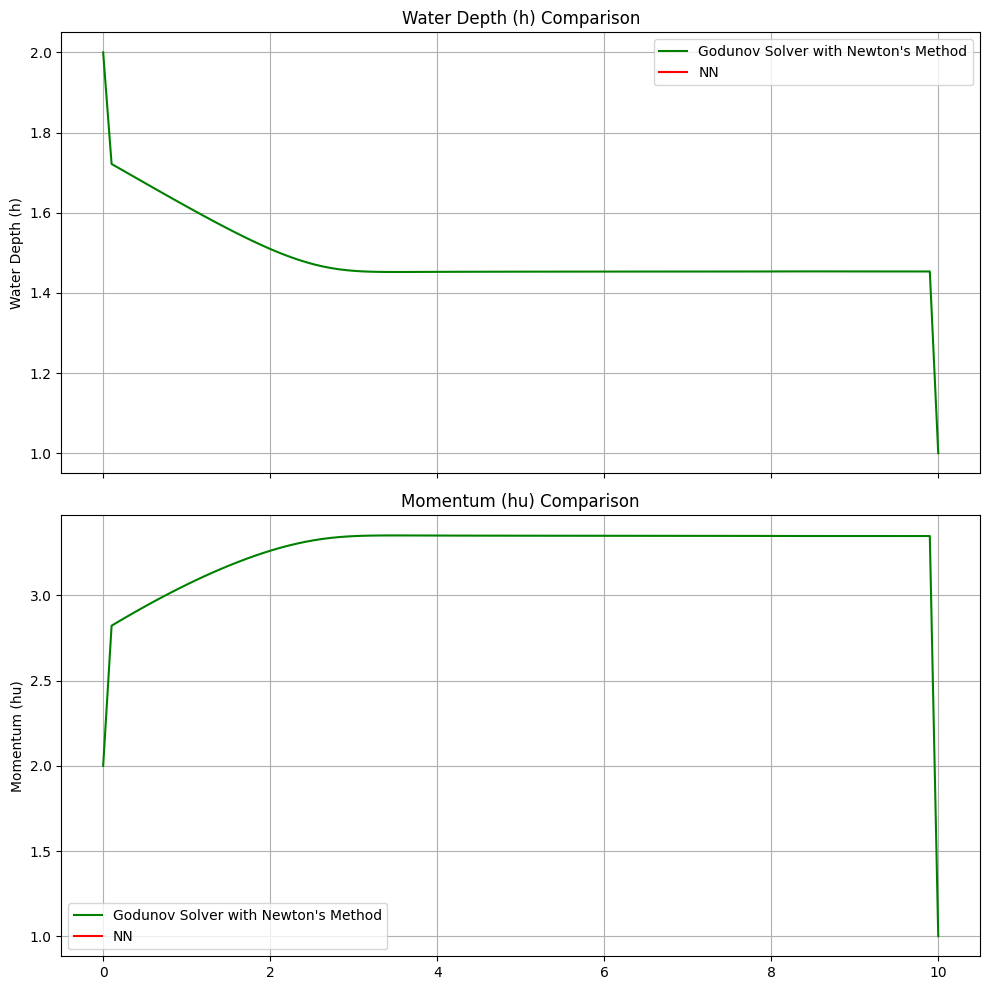

In [68]:
# h_approx, hu_approx = compute(h, hu, solver=0)
# h_iter, hu_iter = compute(h, hu, solver_scheme='godunov_iter')
h_newton, hu_newton = compute(h.copy(), hu.copy(), solver_scheme='godunov_newton')
# print('------------')
# h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')
# h_cabaret_nn, hu_cabaret_nn = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_nn')
h_nn, hu_nn = compute(h, hu, solver_scheme='godunov_nn')
# Add a call to the cabaret solver
# h_cabaret, hu_cabaret = compute(h, hu, solver_scheme='cabaret')


# Plot final results using subplots
x = np.linspace(0, L, nx)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot water depth (h)
# axes[0].plot(x, h_approx, label='Approximate Solve', linestyle='-', color='blue')
# axes[0].plot(x, h_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[0].plot(x, h_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
# axes[0].plot(x, h_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[0].plot(x, h_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='blue')
axes[0].plot(x, h_nn, label='NN', linestyle='-', color='red')
axes[0].set_ylabel('Water Depth (h)')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Water Depth (h) Comparison')

# Plot momentum (hu)
# axes[1].plot(x, hu_approx, label='Approximate Solver', linestyle='-', color='blue')
# axes[1].plot(x, hu_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[1].plot(x, hu_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
# axes[1].plot(x, hu_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[1].plot(x, hu_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='xkcd:sky blue')
axes[1].plot(x, hu_nn, label='NN', linestyle='-', color='red')
axes[1].set_ylabel('Momentum (hu)')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Momentum (hu) Comparison')

# Adjust layout
plt.tight_layout()


# Save the plot as a PNG file
plt.savefig('myplot.png')

plt.show()

In [ ]:
h_cabaret

In [ ]:
riemann_solver_newton(1, 1, 2, -1)

In [ ]:
riemann_solver_newton(2, 1, 4, -1)

In [1]:
from models import *
import torch

In [2]:
model = load_nn('nn', path='checkpoints/model_2.pt')

In [108]:
inputs = torch.tensor([1, 0, 1.5, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([ 1.2869, -0.6917], device='cuda:0', grad_fn=<ViewBackward0>)

In [109]:
inputs = torch.tensor([1.5, 0, 2, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([ 1.7780, -0.5530], device='cuda:0', grad_fn=<ViewBackward0>)

In [110]:
inputs = torch.tensor([1, 0, 1, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([1.0495, 0.0116], device='cuda:0', grad_fn=<ViewBackward0>)

In [111]:
inputs = torch.tensor([2, 0, 2, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([2.0240, 0.0415], device='cuda:0', grad_fn=<ViewBackward0>)

In [3]:
from solvers import riemann_solver_newton

In [20]:
riemann_solver_newton(3.9004723969779596,1.6745589456260106,7.104538780549098,4.969326175030133)

{'flux': array([ -8.47817395, 150.17954414,   5.27735406,  -1.60651983]),
 'star': array([ 5.27735406, -1.60651983]),
 'data': array([2]),
 'velocity': array([None, None, 6.740417932848074, 5.5874290401043085], dtype=object)}

In [13]:
riemann_solver_newton(1, 1, 2, 1)

{'flux': array([-0.86924168, 12.2611741 ,  1.5495649 , -0.56095855]),
 'star': array([ 1.5495649 , -0.56095855]),
 'data': array([3]),
 'velocity': array([None, None, 3.8677207139459924, 3.3372414402389974], dtype=object)}

In [15]:
riemann_solver_newton(2, 2, 4, 2)['star']

array([ 1.52127747, -0.55076185])

In [52]:
for i in range(100):
    hL, huL, hR, huR = map(lambda x: x.item(), train_X_tensor[i])
    # print(hL, huL, hR, huR)
    solution = riemann_solver_newton(hL, huL, hR, huR)
    print(solution if not np.allclose(solution['flux'][2:], solution['star']) else None)

None
None
None
None
None
None
{'flux': array([9.56872559e+00, 3.05259017e+02, 3.00379008e-01, 3.18555070e+01]), 'star': array([7.13310236, 3.67426162]), 'data': array([5]), 'velocity': array([2.4353625712230738, None, None, None], dtype=object)}
{'flux': array([ 7.99737913, 51.34848792,  1.86835315,  4.28044297]), 'star': array([1.78267758, 4.47903116]), 'data': array([1]), 'velocity': array([-1.1020771089855153, 0.29788228373724035, None, None], dtype=object)}
None
None
None
{'flux': array([ -5.00753117,  80.15916867,   0.31472665, -15.91073128]), 'star': array([ 3.6140794 , -2.33267283]), 'data': array([5]), 'velocity': array([None, None, -1.0374561026536835, None], dtype=object)}
{'flux': array([ 20.93625269, 185.26612356,   3.54889497,   5.89937229]), 'star': array([3.19948926, 6.49524022]), 'data': array([3]), 'velocity': array([-2.287057192373056, 0.8938018831246888, None, None], dtype=object)}
None
None
None
None
None
None
{'flux': array([-0.99017841,  9.14781529,  0.10785139, -